In [31]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import row

%matplotlib inline


# PCAs - general data exploration
* PUDs and TUDs
* Area inundation from SLR 

### PUD and TUD distributions for the PCA network

In [2]:
pudtable = pd.read_csv('../flickr/userdays_avg_annual_bypid.csv')
pudtable.rename(columns={'avg_ann_ud':'pud'}, inplace=True)

In [3]:
tudtable = pd.read_csv('../twitter/userdays_avg_annual_bypid.csv')
tudtable.rename(columns={'avg_ann_ud':'tud'}, inplace=True)

In [4]:
data = pudtable.merge(tudtable, on='pid')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fece398d390>], dtype=object)

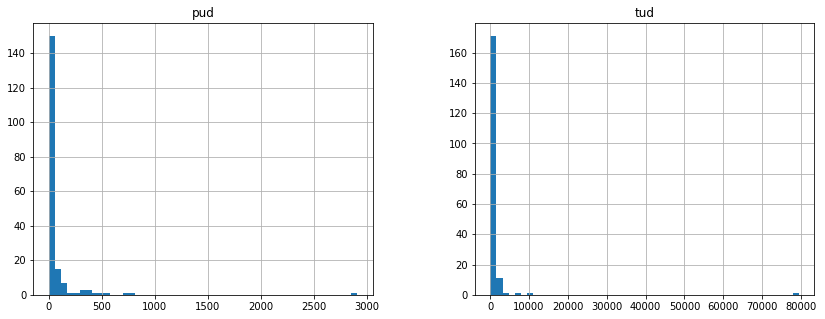

In [5]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.hist('pud', bins=50, ax=axs[0])
data.hist('tud', bins=50, ax=axs[1])

In [6]:
data['logpud'] = np.log1p(data['pud'])
data['logtud'] = np.log1p(data['tud'])

### PUD and TUD are correlated, but capture slightly different visitation patterns

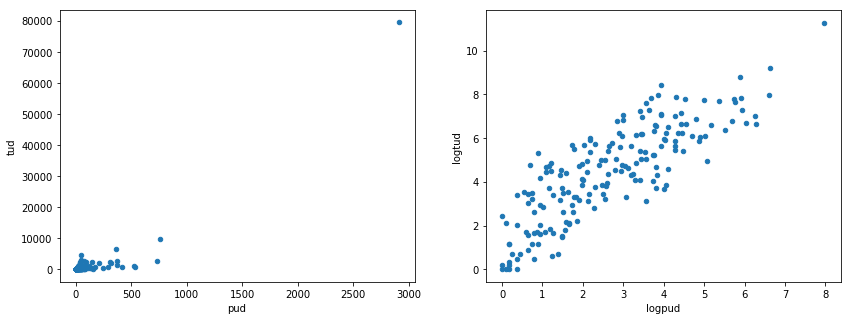

In [7]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='pud', y='tud', ax=axs[0])
data.plot.scatter(x='logpud', y='logtud', ax=axs[1])

### PUD, TUD are influenced by area of PCA

In [8]:
pca_shp = gpd.read_file('../twitter/shp/Priority_Conservation_Areas_current_pid.shp')

In [9]:
pca_shp['area_m2'] = pca_shp.area
data = data.merge(pca_shp[['area_m2', 'pid', 'name']], on='pid')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fece3633748>]], dtype=object)

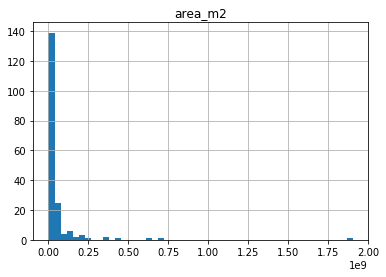

In [10]:
data.hist('area_m2', bins=50)

In [12]:
data['logarea'] = np.log1p(data['area_m2'])

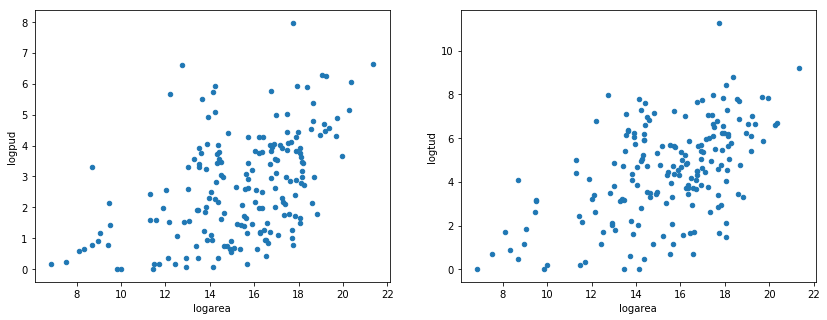

In [13]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='logarea', y='logpud', ax=axs[0])
data.plot.scatter(x='logarea', y='logtud', ax=axs[1])

In [14]:
data['pud_per_m2'] = data['pud']/data['area_m2']
data['tud_per_m2'] = data['tud']/data['area_m2']

#### break visitation density measures into deciles, so we can easily glance at the top 10% of PCAs, for example

In [42]:
data['pudden_tile'] = pd.qcut(data['pud_per_m2'], q=10, labels=False)
data['tudden_tile'] = pd.qcut(data['tud_per_m2'], q=10, labels=False)

In [43]:
data.head()

,pid,pud,tud,logpud,logtud,area_m2,name,logarea,pud_per_m2,tud_per_m2,flood_area,pr_flooded,pudden_tile,tudden_tile
0,0,7.636364,29.8,2.155982,3.427515,1.193295e+08,Blue Ridge Hills (Vaca Mountains),18.597399,6.399395e-08,2.497288e-07,0.000000,0.000000,0,0
1,1,4.909091,248.6,1.776492,5.519860,4.193444e+07,Western Hills (including part of the Vallejo L...,17.551618,1.170658e-07,5.928301e-06,0.000000,0.000000,1,3
2,2,49.909091,4582.4,3.930042,8.430196,6.883717e+07,Tri City and County Cooperative Planning Area,18.047254,7.250312e-07,6.656869e-05,7708.263797,0.000112,3,7
3,3,2.363636,87.0,1.213023,4.477337,1.839385e+07,Vacaville-Fairfield-Solano Greenbelt and Cemen...,16.727527,1.285015e-07,4.729843e-06,0.000000,0.000000,1,3
4,4,50.636364,286.0,3.944226,5.659482,1.975971e+07,Gateway to the San Mateo County Coast,16.799155,2.562607e-06,1.447390e-05,0.000000,0.000000,5,5


## Explore PCA SLR inundation

What percentage of each PCA (and the network as a whole) is vulnerable to SLR inundation?  
And how does recreation importance of PCAs vary with SLR vulnerability?

In [15]:
# SLR shapefiles, downloaded as .gdb from https://coast.noaa.gov/slrdata/
# explored in QGIS and exported shps for appropriate layers
slr = gpd.read_file('../slr/CA_MTR23_slr_6ft.shp')
slr.crs

{'init': 'epsg:26910'}

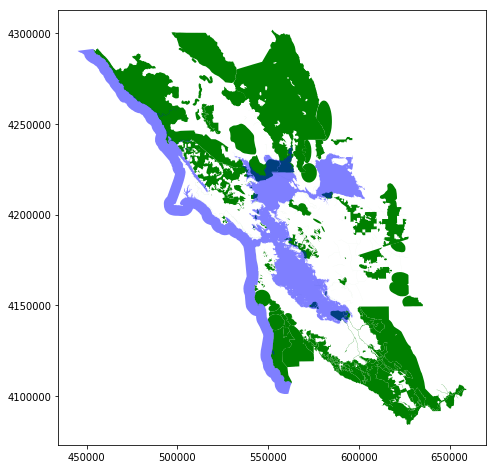

In [16]:
base = pca_shp.plot(color='green', edgecolor=None, figsize=(8,8))
slr.plot(ax=base, color='blue', alpha=0.5)

In [17]:
inundation = pd.read_csv('../pca/pca_area_inundated_slr6ft.csv')

In [20]:
inundation.shape[0] == data.shape[0]

True

In [21]:
data['flood_area'] = inundation['area_m2']
data['pr_flooded'] = data['flood_area'] / data['area_m2']

### PCAs most inundated -- sorted by proportion of their area that would flood with 6ft of SLR

In [35]:
data[['name', 'pud', 'tud', 'area_m2', 'flood_area', 'pr_flooded']].sort_values(by='pr_flooded', ascending=False).head(15)

,name,pud,tud,area_m2,flood_area,pr_flooded
101,San Francisco Bay Area Water Trail,0.181818,0.0,9.292328e+02,9.292328e+02,1.000000
10,"Central Marin Bayfront, Madera Bay Park",40.727273,186.2,1.632486e+06,1.621339e+06,0.993172
56,Baylands,3.363636,3.6,4.137853e+06,4.095131e+06,0.989675
31,Site 1-Coyote Hills,8.636364,15.2,1.536279e+06,1.488682e+06,0.969018
97,San Francisco Bay Area Water Trail,7.454545,22.2,1.300925e+04,1.247229e+04,0.958725
107,Menlo Park and East Palo Alto Baylands,41.545455,183.6,1.084942e+07,1.026776e+07,0.946387
99,San Francisco Bay Area Water Trail,0.909091,1.4,4.181545e+03,3.844931e+03,0.919500
104,San Francisco Bay Area Water Trail,2.272727,5.2,8.363091e+03,7.572592e+03,0.905478
103,San Francisco Bay Area Water Trail,26.090909,59.4,6.040011e+03,5.459231e+03,0.903845
145,Baylands,150.545455,445.0,3.835250e+07,3.421522e+07,0.892125


### SLR vulnerability related to Visitation Rates

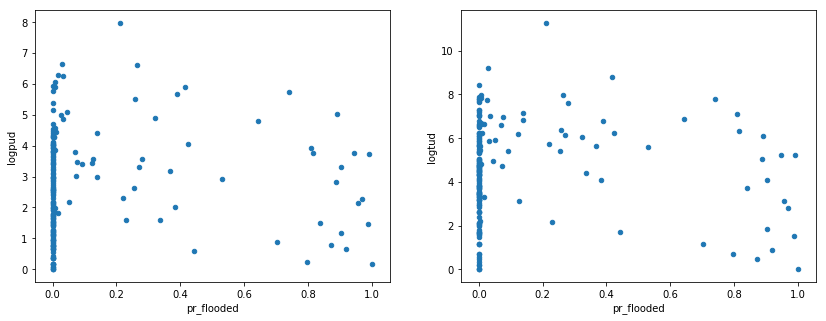

In [23]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='pr_flooded', y='logpud', ax=axs[0])
data.plot.scatter(x='pr_flooded', y='logtud', ax=axs[1])

In [34]:
output_notebook()

source = ColumnDataSource(data)
hover1 = HoverTool(tooltips=[("name", "@name")])
hover2 = HoverTool(tooltips=[("name", "@name")])

p = figure(plot_width=400, plot_height=400, tools=[hover1],
           title="SLR vulnerability related to Visitation Rates")

p.circle('pr_flooded', 'pud_per_m2', size=5, color='blue', alpha=0.5, source=source)
p.xaxis.axis_label = 'pr_flooded'
p.yaxis.axis_label = 'pud_per_m2'

p2 = figure(plot_width=400, plot_height=400, tools=[hover2],
           title="SLR vulnerability related to Visitation Rates")

p2.circle('pr_flooded', 'tud_per_m2', size=5, color='red', alpha=0.5, source=source)
p2.xaxis.axis_label = 'pr_flooded'
p2.yaxis.axis_label = 'tud_per_m2'

show(row(p, p2), notebook_handle=True)

Loading BokehJS ...

### PCAs with greater than 30% area flooded and relatively dense visitation

In [54]:
(data[['name', 'pud_per_m2', 'area_m2', 'pr_flooded']]
.loc[(data['pr_flooded'] > 0.3) & (data['pudden_tile'] >= 8)]
.sort_values(by='pud_per_m2', ascending=False)
)

,name,pud_per_m2,area_m2,pr_flooded
103,San Francisco Bay Area Water Trail,0.004320,6.040011e+03,0.903845
86,San Francisco Bay Trail - Bay Area Ridge Trail,0.001459,2.003524e+05,0.389694
97,San Francisco Bay Area Water Trail,0.000573,1.300925e+04,0.958725
104,San Francisco Bay Area Water Trail,0.000272,8.363091e+03,0.905478
105,San Francisco Bay Area Water Trail,0.000252,3.252313e+03,0.442986
153,Oakland Priority Estuaries,0.000226,1.361955e+06,0.739891
99,San Francisco Bay Area Water Trail,0.000217,4.181545e+03,0.919500
102,San Francisco Bay Area Water Trail,0.000196,6.040011e+03,0.872304
101,San Francisco Bay Area Water Trail,0.000196,9.292328e+02,1.000000
100,San Francisco Bay Area Water Trail,0.000184,7.898476e+03,0.704331


In [55]:
(data[['name', 'tud_per_m2', 'area_m2', 'pr_flooded']]
.loc[(data['pr_flooded'] > 0.3) & (data['tudden_tile'] >= 8)]
.sort_values(by='tud_per_m2', ascending=False)
)

,name,tud_per_m2,area_m2,pr_flooded
103,San Francisco Bay Area Water Trail,0.009834,6.040011e+03,0.903845
86,San Francisco Bay Trail - Bay Area Ridge Trail,0.004433,2.003524e+05,0.389694
153,Oakland Priority Estuaries,0.001789,1.361955e+06,0.739891
97,San Francisco Bay Area Water Trail,0.001706,1.300925e+04,0.958725
29,Potential Oakland Gateway Area,0.001597,7.507035e+05,0.809629
105,San Francisco Bay Area Water Trail,0.001414,3.252313e+03,0.442986
155,Oakland Recreational Trails,0.000994,8.148263e+04,0.335776
15,Bothin Waterfront,0.000683,8.236991e+05,0.816325
104,San Francisco Bay Area Water Trail,0.000622,8.363091e+03,0.905478
98,San Francisco Bay Area Water Trail,0.000538,1.858465e+03,0.796180


In [56]:
data.to_csv('../pca/pca_data_4join.csv', index=False)